# Battery & BMS Time-series Investigation 
1. Companies that purchases BMS and sells battery
2. Signs of propagation? What time scale? Go into their transactions, plot out quarter by quarter, aggregated BMS, battery.
3. Correlation (Pearson)
    a. BMS, Battery time series
    b. Global parameter needed? across companies
4. Poisson? 


In [19]:
%load_ext autoreload
%autoreload 2

from sc_experiments import *
import matplotlib.pyplot as plt 
import numpy as np
from scipy.stats.stats import pearsonr

/tmp/ipykernel_158758/4214512154.py:7: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [20]:
# load index
index = pd.read_csv("s3://supply-web-data-storage/CSV/index_hs6.csv")
index.head()

,supplier_t,supplier_id,buyer_t,buyer_id,hs6,st,et,bill_count,quantity_sum,weight_sum,amount_sum
0,NaN,NaN,hitachi rail europe ltd,961db080904f3ba98b0f62302ba82fe8,271019,2022-07-01,2022-07-01,1,0.0,0.0,0.0
1,NaN,NaN,hitachi rail europe ltd,961db080904f3ba98b0f62302ba82fe8,280430,2022-10-01,2022-10-01,1,0.0,0.0,0.0
2,NaN,NaN,hitachi rail europe ltd,961db080904f3ba98b0f62302ba82fe8,281122,2021-12-01,2021-12-01,1,0.0,0.0,0.0
3,NaN,NaN,hitachi rail europe ltd,961db080904f3ba98b0f62302ba82fe8,300660,2022-10-01,2022-10-01,1,0.0,0.0,0.0
4,NaN,NaN,hitachi rail europe ltd,961db080904f3ba98b0f62302ba82fe8,320820,2019-01-01,2020-12-01,8,0.0,0.0,0.0


In [21]:
# load BOM dictionary
bom = parse_battery_bom()
print('num parts', len(bom))
print('BMS codes', bom['BMS'])

num parts 16
BMS codes ['850450', '850730', '850780', '850790', '853222', '853223', '853321', '853340', '853630', '853641', '853890', '854190', '854239', '854290', '854411', '854442', '854449']


In [23]:
# get companies that sell battery and buy BMS
battery_suppliers = index[index.hs6 == BATTERY].groupby('supplier_t')['bill_count'].sum().rename('battery_supply_count')
bms_buyers = index[index.hs6.isin(bom['BMS'])].groupby('buyer_t')['bill_count'].sum().rename('bms_buy_count')
merged = pd.merge(battery_suppliers, bms_buyers, left_index=True, right_index=True, how='inner')  # must have both
display(merged.sort_values('battery_supply_count', ascending=False).head(30))
display(merged.sort_values('bms_buy_count', ascending=False).head(30)) # TODO: panasonic, chinese companies

,battery_supply_count,bms_buy_count
sevt,2540,15111
sehc,689,107115
"samsung electronics vietnam thai nguyen co.,ltd",658,8
cong ty tnhh dien tu samsung hcmc ce complex,631,270
luxshare precision limited,437,3877
"samsung electronics co., ltd",350,85
samsung electronics vietnam company limited,264,1170
"hansol electronics vietnam co.,ltd",215,2
samsung electronics vietnam thai nguyen company limited,211,342
cong ty tnhh samsung electronics viet nam thai nguyen,146,130


,battery_supply_count,bms_buy_count
sehc,689,107115
vivo mobile india private limited,11,19571
lgevh,136,15974
sevt,2540,15111
lxvn,21,15032
samsung india electronics private limited,44,14589
oppo mobiles india private limited,2,6537
ford otomotiv sanayi anonim sirketi,2,4233
luxshare precision limited,437,3877
aselsan elektronik sanayi ve tic.a.s.,3,3668


It seems like samsung, samsung electronics, se are very popular. 
Also, lg is fairly popular.

In [24]:
import http.cookiejar as cookielib
import pandas as pd
import requests
import warnings
import logging
import sqlite3
import boto3
import glob
import json
import time
import math
import tqdm
import sys
import os
import datetime

sys.path.append("/opt/libs")
from apiclass import APIClass,RedshiftClass
from apikeyclass import APIkeyClass
from dotenv import load_dotenv

warnings.filterwarnings('ignore')
rs = RedshiftClass('zhiyin','Zhiyin123')

Successful connection！
 


In [25]:
import re
def preprocess_transaction_data(companies=[]):
    '''
    companies [List]: records list of companies (SQL format) to query. If empty list, assume all companies
    '''
    if len(companies) >= 1:
        supplier_string = f"supplier_t like '{companies[0]}'" + "".join([f" or supplier_t like '{company}'" for company in companies[1:]])
        query = f"select * from logistic_data where hs_code like '{BATTERY}%' and ({supplier_string});"
    else:
        query = f"select * from logistic_data where hs_code like '{BATTERY}%';"
    print("Query is", query)
    df = rs.query_df(query)
    print(len(df), len(df.drop_duplicates()))
    
    # save transactions
    df = df.drop_duplicates()
    df = df.sort_values('date')
    if len(companies) >= 1:
        csv_name = " ".join(re.findall("[a-zA-Z]+", companies[0]))
    else:
        csv_name = "all"
    df.to_csv('battery_supplier_%s.csv' % csv_name, index=False)
    df.head()
    
    
    # get transactions where company is buying BMS
    all_dfs = []
    for hs in bom['BMS']:
        if len(companies) >= 1:
            buyer_string = f"buyer_t like '{companies[0]}'" + "".join([f" or buyer_t like '{company}'" for company in companies[1:]])
            query = f"select * from logistic_data where hs_code like '{hs}%' and ({buyer_string});"
        else:
            query = f"select * from logistic_data where hs_code like '{hs}%';"
        df = rs.query_df(query)
        if df is not None:
            print(hs, '->', len(df), len(df.drop_duplicates()))
            all_dfs.append(df.drop_duplicates())
        else:
            # no results found for this query
            print(hs, '-> None')
    all_dfs = pd.concat(all_dfs)
    assert(len(all_dfs)==len(all_dfs.drop_duplicates()))  # should be the same length

    # save transactions
    all_dfs = all_dfs.sort_values('date')
    all_dfs.to_csv('bms_buyer_%s.csv' % csv_name, index=False)
    all_dfs.head()
    
    return csv_name

In [272]:
csv_name = preprocess_transaction_data(companies=[])
print(csv_name)

850450 -> 3152873 569748
850730 -> 596 405
850780 -> 3874 1257
850790 -> 54910 19177
853222 -> 46737 14694
853223 -> 49301 14820
853321 -> 1813684 370648
853340 -> 447732 124193
853630 -> 26479 5940
853641 -> 53321 14355
853890 -> 347568 87739
854190 -> 4268 1093
854239 -> 1445481 263627
854290 -> 73206 19047
854411 -> 10065 3471
854442 -> 2427391 212856
854449 -> 413910 140492
all


In [242]:
csv_name = preprocess_transaction_data(companies=['%samsung%', 'sehc', 'sevt'])

Query is select * from logistic_data where hs_code like '850760%' and (supplier_t like '%samsung%' or supplier_t like 'sehc' or supplier_t like 'sevt');
440764 42576
850450 -> 863960 96990
850730 -> None
850780 -> 515 83
850790 -> 3606 2232
853222 -> 20428 3561
853223 -> 3590 910
853321 -> 1321620 141602
853340 -> 49883 9139
853630 -> 10349 1326
853641 -> 2919 656
853890 -> 7345 1992
854190 -> 2 1
854239 -> 1021814 136150
854290 -> 152 94
854411 -> 962 625
854442 -> 307465 79673
854449 -> 154683 44647


In [26]:
csv_name = preprocess_transaction_data(companies=['%lg %', 'lgdvh', 'lgevh', 'lgitvh'])
print(csv_name)

Query is select * from logistic_data where hs_code like '850760%' and (supplier_t like '%lg %' or supplier_t like 'lgdvh' or supplier_t like 'lgevh' or supplier_t like 'lgitvh');
2649 1281
850450 -> 56349 43373
850730 -> 3 1
850780 -> 14 14
850790 -> 104 70
853222 -> 3975 3156
853223 -> 49 19
853321 -> 96232 74744
853340 -> 4230 3228
853630 -> 2 2
853641 -> 128 96
853890 -> 5237 1095
854190 -> None
854239 -> 5853 4434
854290 -> 4 2
854411 -> 46 15
854442 -> 19920 8415
854449 -> 157 62
lg


In [27]:
def get_transaction_time_df(csv_name='samsung'):
    supply_df = pd.read_csv('battery_supplier_%s.csv' % csv_name)
    buy_df = pd.read_csv('bms_buyer_%s.csv' % csv_name)
    print(len(supply_df), len(buy_df))

    # convert date to datetime
    supply_df['datetime'] = pd.to_datetime(supply_df.date)
    buy_df['datetime'] = pd.to_datetime(buy_df.date)

    # extract month from date string
    supply_df['month'] = supply_df.date.apply(lambda x: x.rsplit('-', 1)[0])
    buy_df['month'] = buy_df.date.apply(lambda x: x.rsplit('-', 1)[0])

    # convert month to datetime
    supply_df['month_datetime'] = pd.to_datetime(supply_df.month)
    buy_df['month_datetime'] = pd.to_datetime(buy_df.month)

    # extract week from datetime.dt
    supply_df['week'] = supply_df.datetime.dt.strftime("%G-%V-1")
    buy_df['week'] = buy_df.datetime.dt.strftime("%G-%V-1")

    # convert week to datetime
    supply_df['week_datetime'] = supply_df.week.apply(lambda x: datetime.date.fromisocalendar(int(x.rsplit('-', 2)[0]), int(x.rsplit('-', 2)[1]), 1))
    buy_df['week_datetime'] = buy_df.week.apply(lambda x: datetime.date.fromisocalendar(int(x.rsplit('-', 2)[0]), int(x.rsplit('-', 2)[1]), 1))

    display(supply_df.head()[['date', 'datetime', 'month', 'month_datetime', 'week', 'week_datetime']])
    
    return supply_df, buy_df
    
# supply_df, buy_df = get_transaction_time_df('samsung')

In [28]:
def get_time_col(time):
    if time.lower()=='daily':
        return 'datetime'
    elif time.lower()=='weekly':
        return 'week_datetime'
    elif time.lower()=='monthly':
        return 'month_datetime'
    raise Exception("Time window is not supported")

def plot_time_versus_sale_purchase(supply_df, buy_df, time='weekly'):
    '''
    time: supports 'daily', 'weekly', or 'monthly'
    '''
    time_col = get_time_col(time)
    
    # plot time-ly sales vs daily purchases
    supply_summary = supply_df.groupby(time_col)[['quantity', 'amount']].sum()
    buy_summary = buy_df.groupby(time_col)[['quantity', 'amount']].sum()

    # plot quantity
    fig, axes = plt.subplots(2, 1, figsize=(8, 7), sharex=True)
    ax = axes[0]           
    ax.set_title(time+' sales of battery', fontsize=12)
    ax.plot(supply_summary.index, supply_summary.quantity.values)
    ax.set_ylabel('Total quantity', fontsize=12)
    ax = axes[1]
    ax.set_title(time+' purchases of BMS', fontsize=12)
    ax.plot(buy_summary.index, buy_summary.quantity.values)
    ax.set_ylabel('Total quantity', fontsize=12)
    plt.show()

    # plot amount
    fig, axes = plt.subplots(2, 1, figsize=(8, 7), sharex=True)
    ax = axes[0]           
    ax.set_title(time+' sales of battery', fontsize=12)
    ax.plot(supply_summary.index, np.log(supply_summary.amount.values))
    ax.set_ylabel('Total amount, log ($)', fontsize=12)
    ax = axes[1]
    ax.set_title(time+' purchases of BMS', fontsize=12)
    ax.plot(buy_summary.index, np.log(buy_summary.amount.values))
    ax.set_ylabel('Total amount, log ($)', fontsize=12)
    plt.show()

In [29]:
# compare 'time'-ly quantity per BMS HS code
def compare_sale_purchase_quantity_per_hscode(supply_df, buy_df, time='weekly'):
    '''
    time: supports 'daily', 'weekly', or 'monthly'
    '''
    time_col = get_time_col(time)
    
    supply_summary = supply_df.groupby(time_col).quantity.sum()
    buy_df['hs_code_str'] = buy_df.hs_code.astype(str)  # convert HS code to str

    fig, axes = plt.subplots(2, 1, figsize=(8, 7), sharex=True)
    ax = axes[0]           
    ax.set_title(time+' sales of battery', fontsize=12)
    ax.plot(supply_summary.index, supply_summary.values)
    ax.set_ylabel('Total quantity', fontsize=12)
    ax = axes[1]
    ax.set_title(time+' purchases of BMS', fontsize=12)
    for hs in bom['BMS']:
        sub_buy_df = buy_df[buy_df.hs_code_str.str.contains(hs)]
        if len(sub_buy_df) > 1000:
            buy_summary = sub_buy_df.groupby(time_col).quantity.sum()
            # merge to find common months
            merged = pd.merge(supply_summary.rename('x'), buy_summary.rename('y'), 
                              left_index=True, right_index=True, how='inner')
            r, p = pearsonr(merged.x, merged.y)
            print(hs, len(sub_buy_df), 'r=%.3f (n=%d, p=%.3f)' % (r, len(merged), p)) # number of transaction, n is number of dates
            # normalize by mean to make comparison easier
            ax.plot(buy_summary.index, buy_summary.values / np.mean(buy_summary.values), label=hs)
        else:
            print(hs, len(sub_buy_df))
    ax.legend(bbox_to_anchor=(1,1))
    ax.set_ylabel('Total quantity (normalized)', fontsize=12)
    plt.show()

In [32]:
def mega_sale_purchase_pipeline(csv_name='samsung'):
    print("Mega Analysis of Sale - Purchase Pipeline on Daily, Weekly, and Monthly Scale\n")
    print("Assume Transaction Data Has Been Queried and Preprocessed...")
    print("Constructing Transaction Time Dataframe...Loading from csv...")
    supply_df, buy_df = get_transaction_time_df(csv_name)
    print("Plotting sale, purchase over time...")
    plot_time_versus_sale_purchase(supply_df, buy_df, 'daily')
    plot_time_versus_sale_purchase(supply_df, buy_df, 'weekly')
    plot_time_versus_sale_purchase(supply_df, buy_df, 'monthly')
    print("Compare sale, purchase quantity per hscode...")
    compare_sale_purchase_quantity_per_hscode(supply_df, buy_df, "daily")
    compare_sale_purchase_quantity_per_hscode(supply_df, buy_df, "weekly")
    compare_sale_purchase_quantity_per_hscode(supply_df, buy_df, "monthly")
    return supply_df, buy_df

Mega Analysis of Sale - Purchase Pipeline on Daily, Weekly, and Monthly Scale

Assume Transaction Data Has Been Queried and Preprocessed...
Constructing Transaction Time Dataframe...Loading from csv...
42576 519681
Plotting sale, purchase over time...


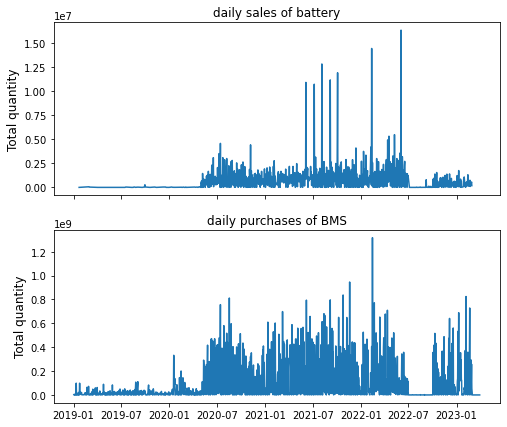

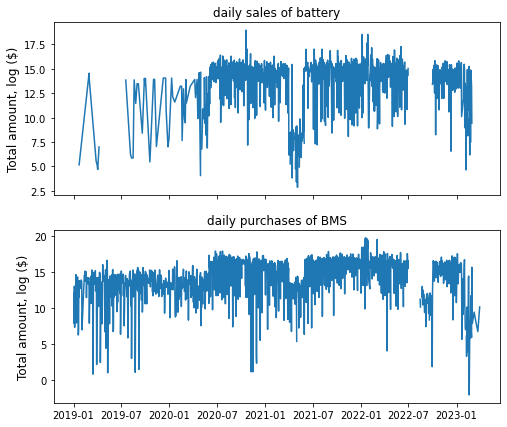

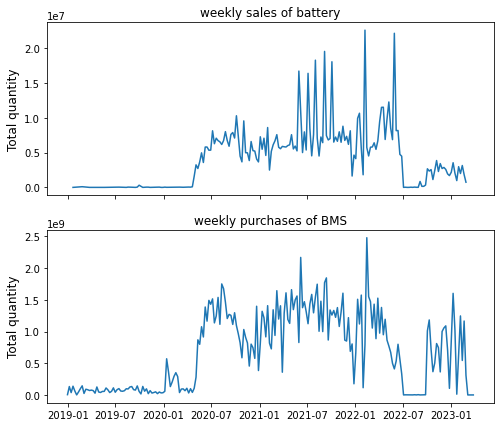

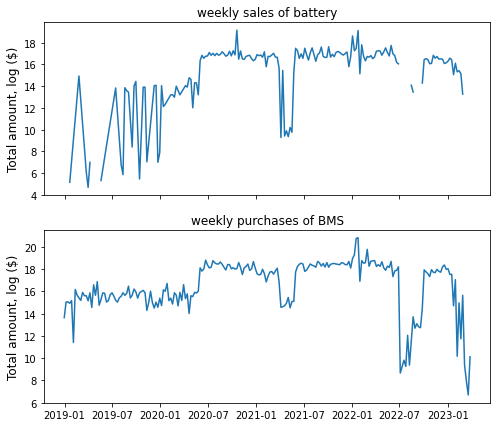

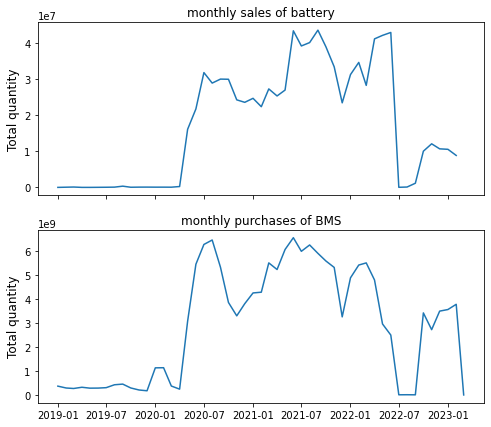

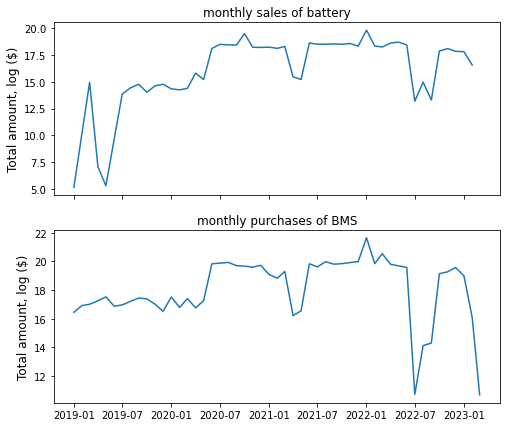

Compare sale, purchase quantity per hscode...
850450 96990 r=0.225 (n=859, p=0.000)
850730 0
850780 83
850790 2232 r=0.060 (n=264, p=0.328)
853222 3561 r=0.074 (n=534, p=0.089)
853223 910
853321 141602 r=0.207 (n=811, p=0.000)
853340 9139 r=0.117 (n=729, p=0.001)
853630 1326 r=0.066 (n=472, p=0.151)
853641 656
853890 1992 r=0.151 (n=531, p=0.000)
854190 1
854239 136150 r=0.269 (n=941, p=0.000)
854290 94
854411 625
854442 79673 r=0.189 (n=930, p=0.000)
854449 44647 r=0.146 (n=738, p=0.000)


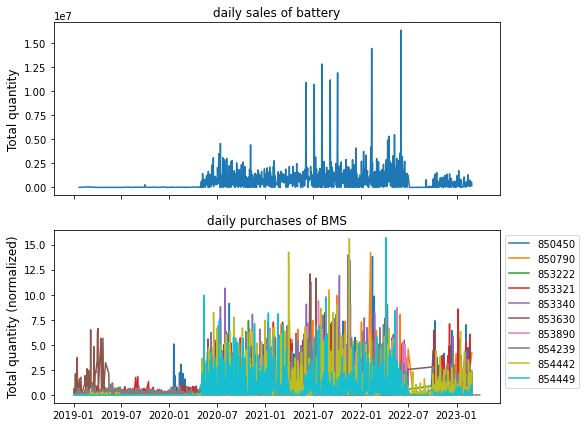

850450 96990 r=0.549 (n=182, p=0.000)
850730 0
850780 83
850790 2232 r=0.339 (n=124, p=0.000)
853222 3561 r=0.303 (n=143, p=0.000)
853223 910
853321 141602 r=0.497 (n=172, p=0.000)
853340 9139 r=0.380 (n=171, p=0.000)
853630 1326 r=0.185 (n=152, p=0.022)
853641 656
853890 1992 r=0.555 (n=144, p=0.000)
854190 1
854239 136150 r=0.634 (n=184, p=0.000)
854290 94
854411 625
854442 79673 r=0.656 (n=184, p=0.000)
854449 44647 r=0.427 (n=157, p=0.000)


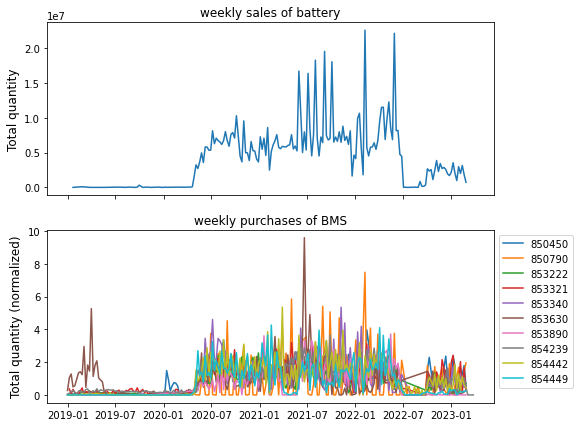

850450 96990 r=0.832 (n=48, p=0.000)
850730 0
850780 83
850790 2232 r=0.687 (n=35, p=0.000)
853222 3561 r=0.728 (n=39, p=0.000)
853223 910
853321 141602 r=0.840 (n=46, p=0.000)
853340 9139 r=0.753 (n=47, p=0.000)
853630 1326 r=0.540 (n=45, p=0.000)
853641 656
853890 1992 r=0.829 (n=38, p=0.000)
854190 1
854239 136150 r=0.909 (n=48, p=0.000)
854290 94
854411 625
854442 79673 r=0.856 (n=48, p=0.000)
854449 44647 r=0.766 (n=45, p=0.000)


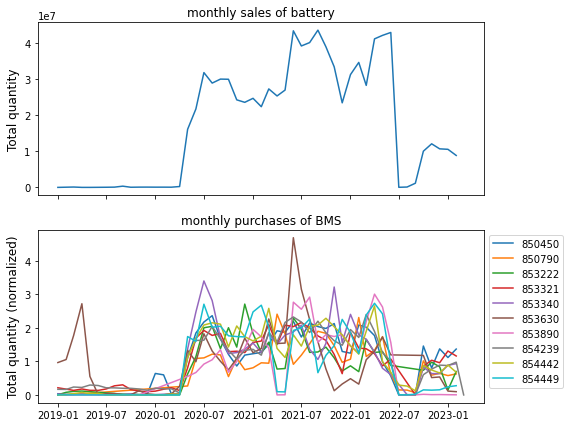

In [255]:
# Q 5.1: How does companies like Samsung? 
supply_df, buy_df = mega_sale_purchase_pipeline('samsung')

Mega Analysis of Sale - Purchase Pipeline on Daily, Weekly, and Monthly Scale

Assume Transaction Data Has Been Queried and Preprocessed...
Constructing Transaction Time Dataframe...Loading from csv...
1281 138726


,date,datetime,month,month_datetime,week,week_datetime
0,2019-01-06,2019-01-06,2019-01,2019-01-01,2019-01-1,2018-12-31
1,2019-01-14,2019-01-14,2019-01,2019-01-01,2019-03-1,2019-01-14
2,2019-04-22,2019-04-22,2019-04,2019-04-01,2019-17-1,2019-04-22
3,2019-09-30,2019-09-30,2019-09,2019-09-01,2019-40-1,2019-09-30
4,2020-04-23,2020-04-23,2020-04,2020-04-01,2020-17-1,2020-04-20


Plotting sale, purchase over time...


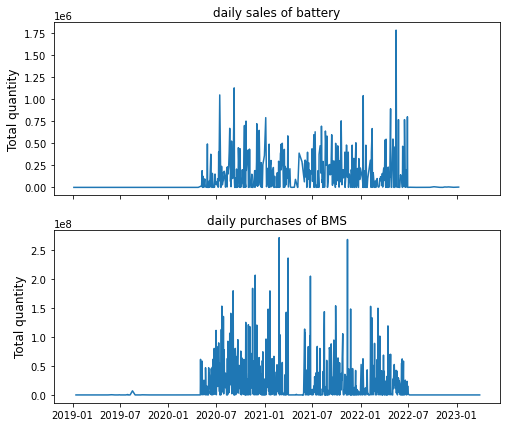

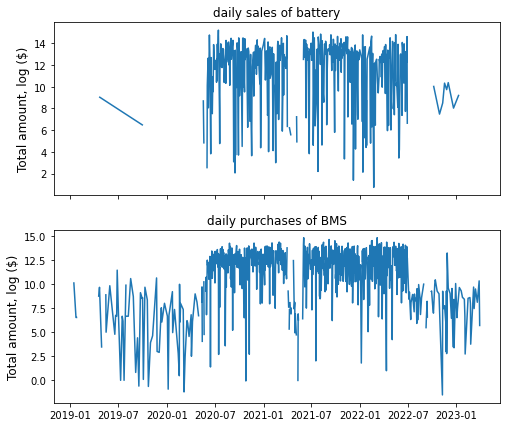

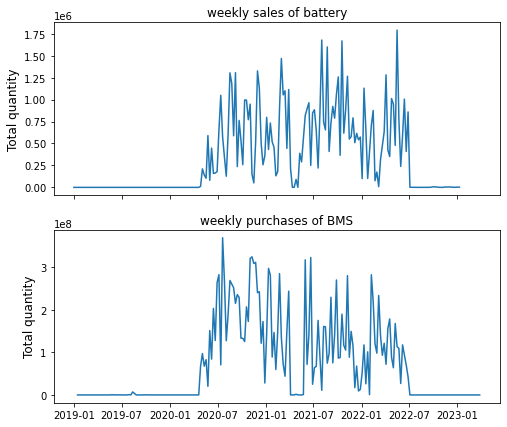

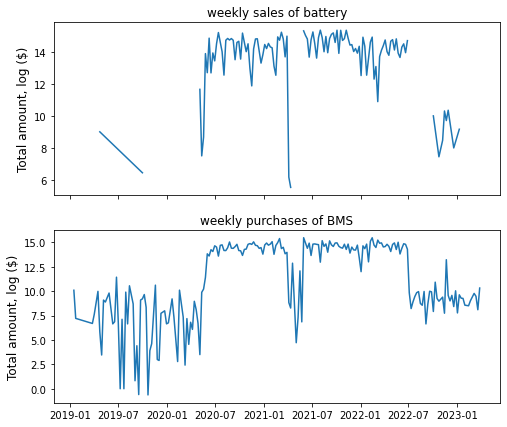

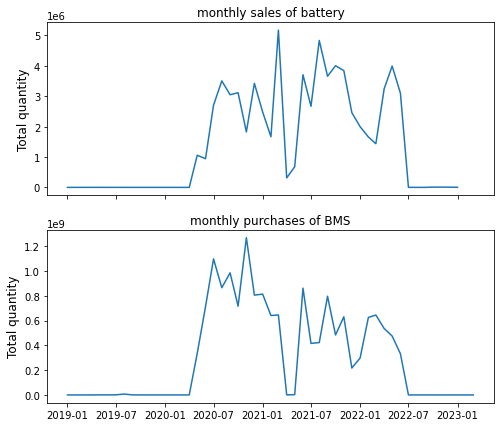

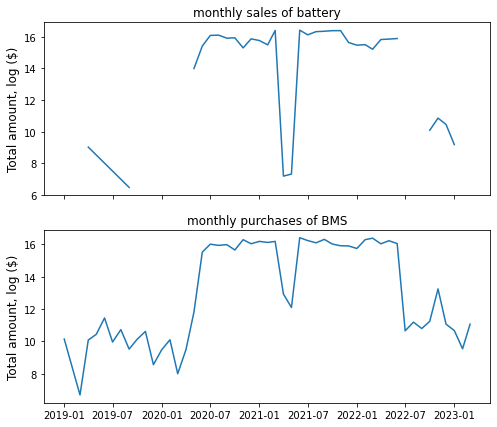

Compare sale, purchase quantity per hscode...
850450 43373 r=-0.018 (n=371, p=0.729)
850730 1
850780 14
850790 70
853222 3156 r=0.017 (n=281, p=0.775)
853223 19
853321 74744 r=0.064 (n=370, p=0.216)
853340 3228 r=-0.044 (n=305, p=0.444)
853630 2
853641 96
853890 1095 r=-0.028 (n=160, p=0.725)
854190 0
854239 4434 r=0.131 (n=353, p=0.014)
854290 2
854411 15
854442 8415 r=0.037 (n=394, p=0.465)
854449 62


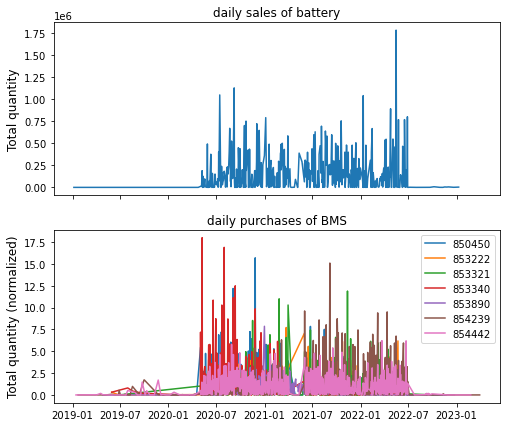

850450 43373 r=-0.062 (n=110, p=0.519)
850730 1
850780 14
850790 70
853222 3156 r=0.013 (n=105, p=0.897)
853223 19
853321 74744 r=0.176 (n=110, p=0.066)
853340 3228 r=-0.201 (n=105, p=0.040)
853630 2
853641 96
853890 1095 r=-0.065 (n=69, p=0.596)
854190 0
854239 4434 r=0.389 (n=121, p=0.000)
854290 2
854411 15
854442 8415 r=0.143 (n=114, p=0.129)
854449 62


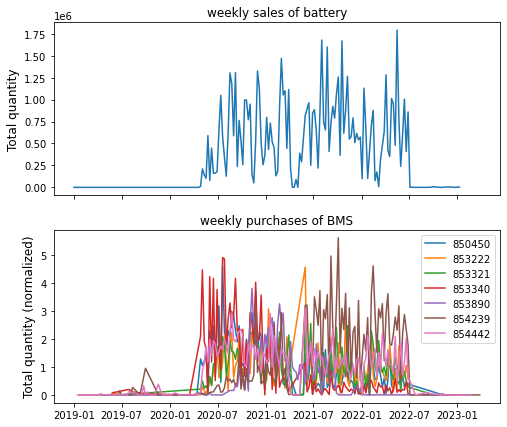

850450 43373 r=0.227 (n=29, p=0.236)
850730 1
850780 14
850790 70
853222 3156 r=0.182 (n=24, p=0.395)
853223 19
853321 74744 r=0.499 (n=27, p=0.008)
853340 3228 r=-0.223 (n=25, p=0.283)
853630 2
853641 96
853890 1095 r=0.198 (n=24, p=0.354)
854190 0
854239 4434 r=0.700 (n=37, p=0.000)
854290 2
854411 15
854442 8415 r=0.716 (n=33, p=0.000)
854449 62


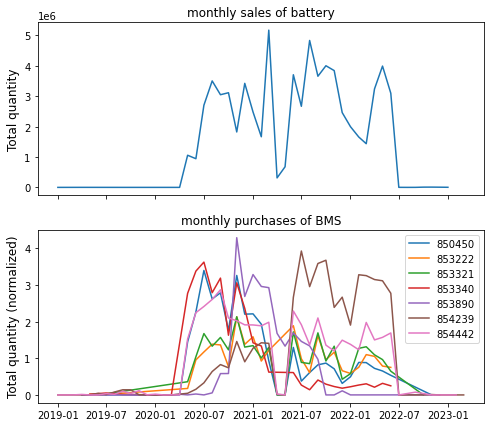

In [36]:
# Q 5.2: How does companies other than Samsung series do? For example, try LG
supply_df, buy_df = mega_sale_purchase_pipeline('lg')

Mega Analysis of Sale - Purchase Pipeline on Daily, Weekly, and Monthly Scale

Assume Transaction Data Has Been Queried and Preprocessed...
Constructing Transaction Time Dataframe...Loading from csv...
97465 1863562
Plotting sale, purchase over time...


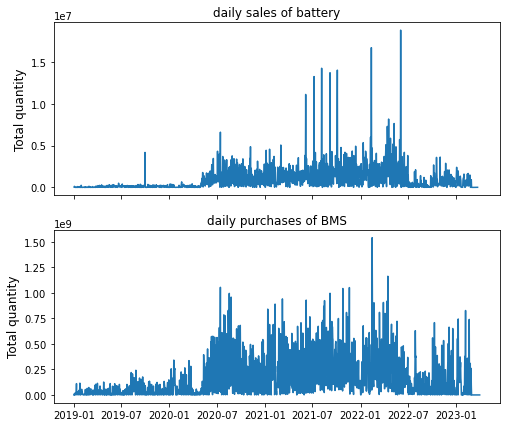

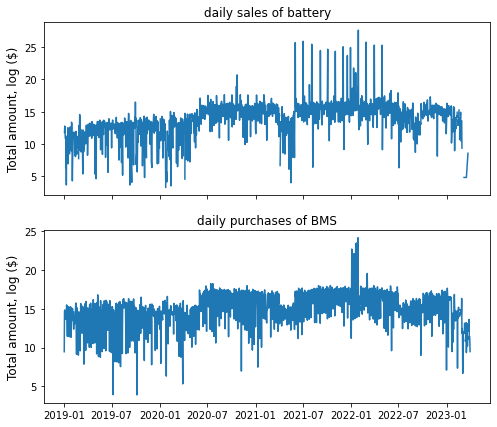

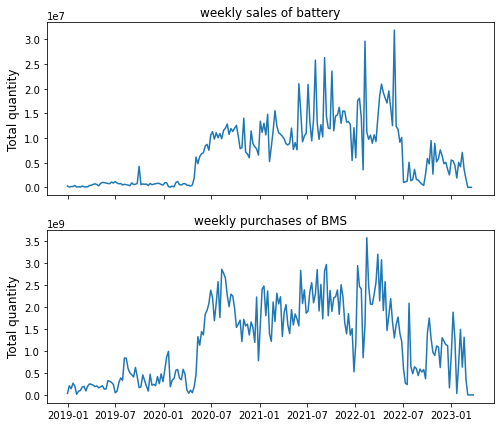

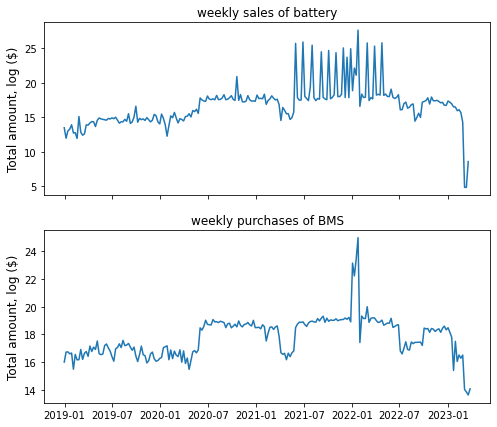

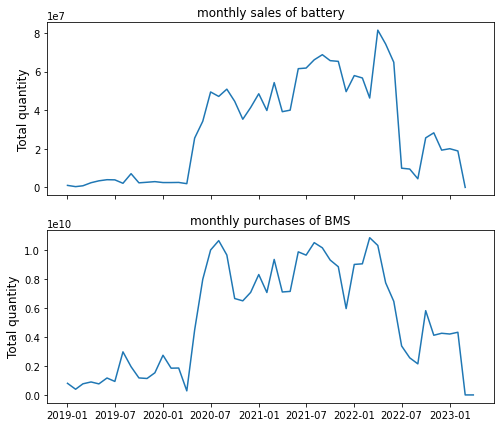

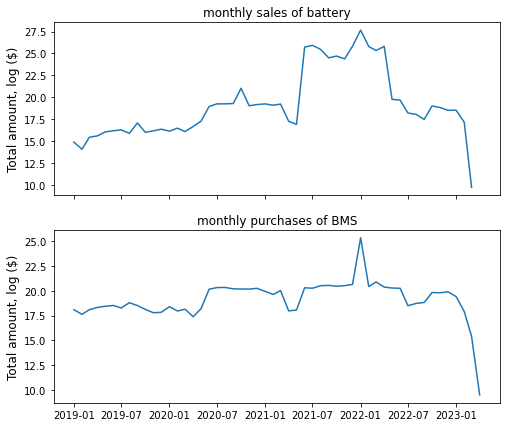

Compare sale, purchase quantity per hscode...
850450 569748 r=0.426 (n=1374, p=0.000)
850730 405
850780 1257 r=-0.072 (n=557, p=0.089)
850790 19177 r=0.283 (n=793, p=0.000)
853222 14694 r=0.258 (n=898, p=0.000)
853223 14820 r=0.003 (n=575, p=0.949)
853321 370651 r=0.422 (n=1298, p=0.000)
853340 124195 r=0.132 (n=1324, p=0.000)
853630 5944 r=0.177 (n=1048, p=0.000)
853641 14355 r=0.075 (n=1258, p=0.008)
853890 87743 r=0.315 (n=1398, p=0.000)
854190 1093 r=0.114 (n=475, p=0.013)
854239 263627 r=0.531 (n=1404, p=0.000)
854290 19047 r=0.075 (n=1229, p=0.008)
854411 3471 r=-0.044 (n=761, p=0.229)
854442 212865 r=0.511 (n=1423, p=0.000)
854449 140500 r=0.156 (n=1331, p=0.000)


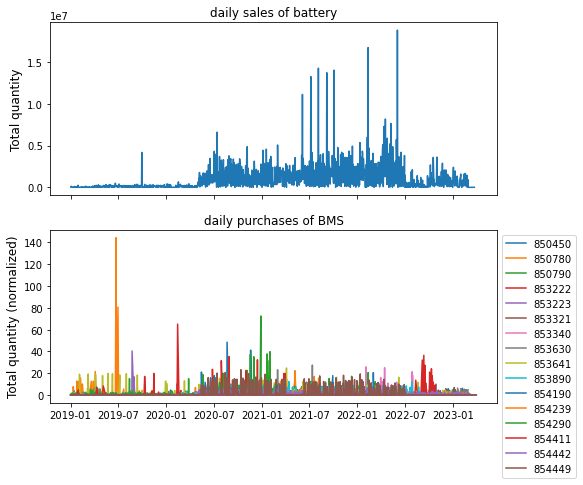

850450 569748 r=0.730 (n=219, p=0.000)
850730 405
850780 1257 r=-0.093 (n=206, p=0.185)
850790 19177 r=0.648 (n=209, p=0.000)
853222 14694 r=0.698 (n=213, p=0.000)
853223 14820 r=0.263 (n=180, p=0.000)
853321 370651 r=0.725 (n=219, p=0.000)
853340 124195 r=0.466 (n=218, p=0.000)
853630 5944 r=0.479 (n=218, p=0.000)
853641 14355 r=0.257 (n=219, p=0.000)
853890 87743 r=0.672 (n=221, p=0.000)
854190 1093 r=0.199 (n=189, p=0.006)
854239 263627 r=0.812 (n=221, p=0.000)
854290 19047 r=0.184 (n=219, p=0.006)
854411 3471 r=-0.033 (n=216, p=0.633)
854442 212865 r=0.821 (n=221, p=0.000)
854449 140500 r=0.560 (n=221, p=0.000)


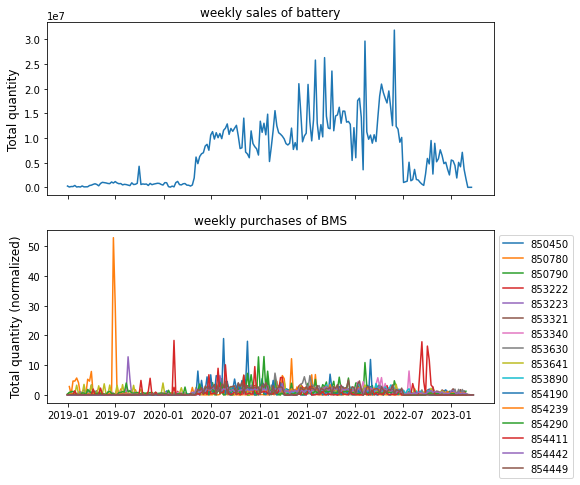

850450 569748 r=0.895 (n=51, p=0.000)
850730 405
850780 1257 r=-0.238 (n=50, p=0.097)
850790 19177 r=0.926 (n=50, p=0.000)
853222 14694 r=0.850 (n=50, p=0.000)
853223 14820 r=0.491 (n=49, p=0.000)
853321 370651 r=0.893 (n=51, p=0.000)
853340 124195 r=0.676 (n=50, p=0.000)
853630 5944 r=0.651 (n=51, p=0.000)
853641 14355 r=0.489 (n=51, p=0.000)
853890 87743 r=0.811 (n=51, p=0.000)
854190 1093 r=0.388 (n=49, p=0.006)
854239 263627 r=0.933 (n=51, p=0.000)
854290 19047 r=0.259 (n=51, p=0.066)
854411 3471 r=-0.032 (n=51, p=0.825)
854442 212865 r=0.917 (n=51, p=0.000)
854449 140500 r=0.814 (n=51, p=0.000)


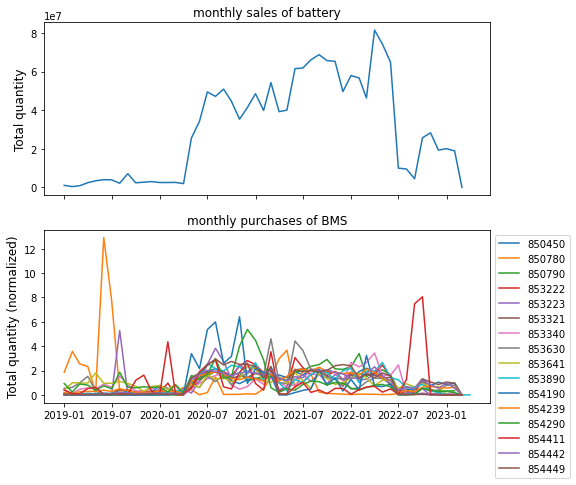

In [273]:
# Q 5.3: What about across companies?
supply_df, buy_df = mega_sale_purchase_pipeline('all')

# Mega Analysis of 100 Battery Supplier
Analyze top 100 battery supplier - identity name and query, correlation plots


# Construct Baseline
baseline measure: compare with general samsung trend, or another common product (has nothing to do with batteries)